In [1]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd

2024-04-29 10:37:28.147232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_file_path = "../data/diabetes_prediction_dataset.csv"
df = pd.read_csv(train_file_path)

# fix some of the data issues
df["smoking_history"] = df["smoking_history"].replace("No Info", "unknown")
df["smoking_history"] = df["smoking_history"].replace("not current", "former")
df["smoking_history"] = df["smoking_history"].replace("ever", "former")

sh_hots = pd.get_dummies(df["smoking_history"], prefix="sh", dtype=int)
df = pd.concat([df, sh_hots], axis=1)
df = df.drop(["smoking_history"], axis=1)

df["gender"] = df["gender"].replace("Male", "male")
df["gender"] = df["gender"].replace("Female", "female")
df["gender"] = df["gender"].replace("Other", "other")

sh_hots = pd.get_dummies(df["gender"], prefix="gender", dtype=int)
df = pd.concat([df, sh_hots], axis=1)
df = df.drop(["gender"], axis=1)

df["age"] = (df["age"] - df["age"].mean()) / df["age"].std()
df["bmi"] = (df["bmi"] - df["bmi"].mean()) / df["bmi"].std()
df["HbA1c_level"] = (df["HbA1c_level"] - df["HbA1c_level"].mean()) / df["HbA1c_level"].std()
df["blood_glucose_level"] = (df["blood_glucose_level"] - df["blood_glucose_level"].mean()) / df["blood_glucose_level"].std()

y = df["diabetes"].to_numpy().reshape(-1, 1)
X = df.drop(["diabetes"], axis=1).to_numpy()

In [3]:
# # randomly split the data into training, cross validation and test sets
random_state = 42

X_train, X_blind, y_train, y_blind = train_test_split(
    X, y, test_size=0.2, random_state=random_state)

X_test, X_cv, y_test, y_cv = train_test_split(
    X_blind, y_blind, test_size=0.5, random_state=random_state)

print(f'tf.__version__={tf.__version__}')
print(f'X.shape={X.shape}')
print(f'X_train.shape={X_train.shape}')
print(f'X_cv.shape={X_cv.shape}')
print(f'X_test.shape={X_test.shape}')
print(f'y.shape={y.shape}')
print(f'y max={np.max(y)} y min={np.min(y)}')

df.head()

tf.__version__=2.16.1
X.shape=(100000, 13)
X_train.shape=(80000, 13)
X_cv.shape=(10000, 13)
X_test.shape=(10000, 13)
y.shape=(100000, 1)
y max=1 y min=0


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,sh_current,sh_former,sh_never,sh_unknown,gender_female,gender_male,gender_other
0,1.692695,0,1,-0.321054,1.001701,0.047704,0,0,0,1,0,1,0,0
1,0.538004,0,0,-0.000116,1.001701,-1.426203,0,0,0,0,1,1,0,0
2,-0.616688,0,0,-0.000116,0.161107,0.489876,0,0,0,1,0,0,1,0
3,-0.261398,0,0,-0.583229,-0.492688,0.416181,0,1,0,0,0,1,0,0
4,1.515050,1,1,-1.081965,-0.679486,0.416181,0,1,0,0,0,0,1,0


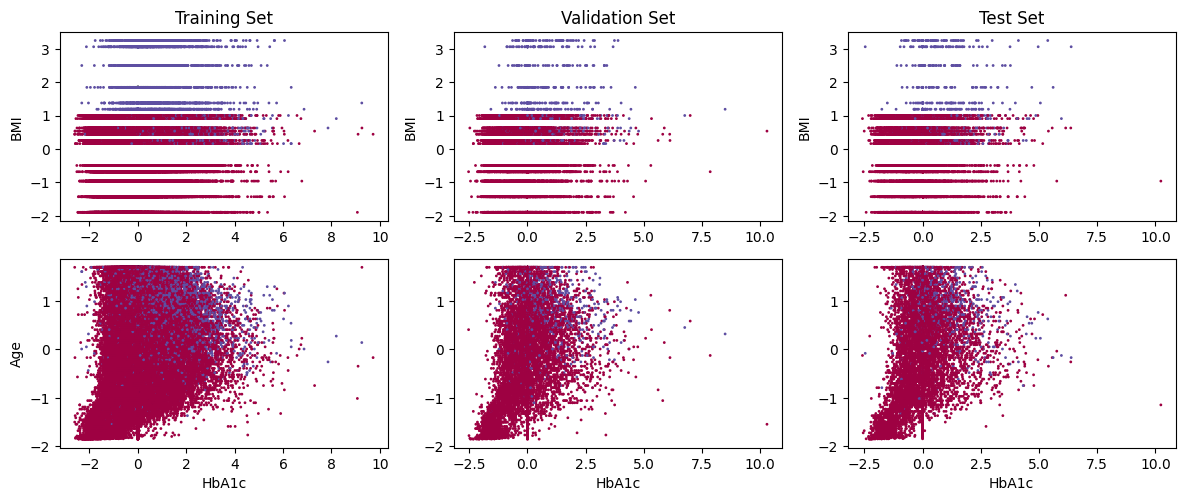

In [4]:
plt.figure(figsize=(8 * 1.8, 3 * 1.8))

plt.subplot(2, 3, 1)
plt.scatter(X_train[:, 3], X_train[:, 4], c=y_train, s=1, cmap=plt.cm.Spectral)
plt.title('Training Set')
plt.ylabel('BMI')

plt.subplot(2, 3, 2)
plt.scatter(X_cv[:, 3], X_cv[:, 4], c=y_cv, s=1, cmap=plt.cm.Spectral)
plt.title('Validation Set')
plt.ylabel('BMI')

plt.subplot(2, 3, 3)
plt.scatter(X_test[:, 3], X_test[:, 4], c=y_test, s=1, cmap=plt.cm.Spectral)
plt.title('Test Set')
plt.ylabel('BMI')

## Second row
plt.subplot(2, 3, 4)
plt.scatter(X_train[:, 3], X_train[:, 0], c=y_train, s=1, cmap=plt.cm.Spectral)
plt.xlabel('HbA1c')
plt.ylabel('Age')

plt.subplot(2, 3, 5)
plt.scatter(X_cv[:, 3], X_cv[:, 0], c=y_cv, s=1, cmap=plt.cm.Spectral)
plt.xlabel('HbA1c')

plt.subplot(2, 3, 6)
plt.scatter(X_test[:, 3], X_test[:, 0], c=y_test, s=1, cmap=plt.cm.Spectral)
plt.xlabel('HbA1c')


plt.show()

In [5]:
# define the error metrics
def recall_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [6]:
# setup the layers
regfac = 0.000002
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(50, activation='relu', kernel_regularizer=l1(regfac)),
    tf.keras.layers.Dense(2, activation='sigmoid', kernel_regularizer=l1(regfac))
    # tf.keras.layers.Dense(10, activation='relu'),
    # tf.keras.layers.Dense(2, activation='sigmoid')
])

epochs = 30
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', recall_m, f1_score])

In [7]:
%%time
class_weights = {0: 1., 1: 3.} 
history = model.fit(X_train, y_train, epochs=epochs, verbose=1, validation_data=(X_cv, y_cv), class_weight=class_weights)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/30


TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int64 of argument 'x'.

In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

print(f'test acc: {test_acc*100:0.2f}% test loss: {test_loss:0.3f}')

NameError: name 'history' is not defined

In [ ]:
Z = np.argmax(model.predict(X_test), axis=1)

In [ ]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Generate the classification report
report = classification_report(y_test, Z, target_names=['healthy', 'diabetes'])
print(report)

In [ ]:
FP = np.sum(np.logical_and(Z == 1, y_test.flatten() == 0))
FN = np.sum(np.logical_and(Z == 0, y_test.flatten() == 1))
TP = np.sum(np.logical_and(Z == 1, y_test.flatten() == 1))
TN = np.sum(np.logical_and(Z == 0, y_test.flatten() == 0))
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
print(f'precision={precision:0.3f} recall={recall:0.3f} f1={f1:0.3f} TP={TP} FP={FP} TN={TN} FN={FN}')